# Part 2 

Use an API to extract box office revenue and profit data to add to your IMDB data and perform exploratory data analysis.

Your stakeholder would like you to extract and save the results for movies that meet all of the criteria established in part 1 of the project (You should already have a filtered dataframe saved from part one as a csv.gz file)

Your stakeholder wants you to extract the budget, revenue, and MPAA Rating (G/PG/PG-13/R), which is also called "Certification".

As a proof-of-concept, they requested you perform a test extraction of movies that started in 2000 or 2001

Each year should be saved as a separate .csv.gz file

In [37]:
import pandas as pd
import numpy as np
import os, time, json
import tmdbsimple as tmdb 
import seaborn as sns
with open('C:/Users/Sean/.edit/tmdb_api.json', 'r') as f:
    login = json.load(f)
from tqdm.notebook import tqdm_notebook
## Display the keys of the loaded dict
login.keys()

# Credential import
tmdb.API_KEY =  login['api-key']


In [2]:
#saving api call data
FOLDER = "Data/"
os.makedirs(FOLDER, exist_ok=True)
os.listdir(FOLDER)

['title_basics.csv.gz',
 'title.akas.csv.gz',
 'title.ratings.csv.gz',
 '.ipynb_checkpoints',
 'tmdb_api_results_2000.json',
 'tmdb_api_results_2001.json',
 'final_tmdb_data_2001.csv.gz']

## Functions

In [36]:
def get_movie_certification(movie_id):
    movie = tmdb.Movies(movie_id)
    info = movie.info()
    releases = movie.releases()
    
    for c in releases['countries']:
        if c['iso_3166_1'] == "US":
            info['certification'] = c['certification']     
    return info

# function for json file creation

def write_json(new_data, filename): 
    """Appends a list of records (new_data) to a json file (filename). 
    Adapted from: https://www.geeksforgeeks.org/append-to-json-file-using-python/"""  
    
    with open(filename,'r+') as file:
        # First we load existing data into a dict.
        file_data = json.load(file)
        ## Choose extend or append
        if (type(new_data) == list) & (type(file_data) == list):
            file_data.extend(new_data)
        else:
             file_data.append(new_data)
        # Sets file's current position at offset.
        file.seek(0)
        # convert back to json.
        json.dump(file_data, file)


In [4]:
# Load in the dataframe from project part 1 as basics:
basics = pd.read_csv('Data/title_basics.csv.gz')

basics


,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,runtimeMinutes,genres
0,tt0035423,movie,Kate & Leopold,Kate & Leopold,0,2001,118,"Comedy,Fantasy,Romance"
1,tt0062336,movie,The Tango of the Widower and Its Distorting Mi...,El Tango del Viudo y Su Espejo Deformante,0,2020,70,Drama
2,tt0069049,movie,The Other Side of the Wind,The Other Side of the Wind,0,2018,122,Drama
3,tt0079644,movie,November 1828,November 1828,0,2001,140,"Drama,War"
4,tt0088751,movie,The Naked Monster,The Naked Monster,0,2005,100,"Comedy,Horror,Sci-Fi"
...,...,...,...,...,...,...,...,...
143286,tt9916170,movie,The Rehearsal,O Ensaio,0,2019,51,Drama
143287,tt9916190,movie,Safeguard,Safeguard,0,2020,95,"Action,Adventure,Thriller"
143288,tt9916270,movie,Il talento del calabrone,Il talento del calabrone,0,2020,84,Thriller
143289,tt9916362,movie,Coven,Akelarre,0,2020,92,"Drama,History"


In [5]:
#defining a list of years
YEARS_TO_GET = [2000,2001]

# defining an errors list
errors = [ ]

## Loop Extraction

In [10]:
# Start of OUTER loop
for YEAR in tqdm_notebook(YEARS_TO_GET, desc='YEARS', position=0):
#Defining the JSON file to store results for year
    JSON_FILE = f'{FOLDER}tmdb_api_results_{YEAR}.json'
# Check if file exists
    file_exists = os.path.isfile(JSON_FILE)
# If it does not exist: create it
    if file_exists == False:
# save an empty dict with just "imdb_id" to the new json file.
        with open(JSON_FILE,'w') as f:
            json.dump([{'imdb_id':0}],f)
#Saving new year as the current df
    df = basics.loc[basics['startYear']==YEAR].copy()
# saving movie ids to list
    movie_ids = df['tconst'].copy()    
# Load existing data from json into a dataframe called "previous_df"
    previous_df = pd.read_json(JSON_FILE)
# filter out any ids that are already in the JSON_FILE
    movie_ids_to_get = movie_ids[~movie_ids.isin(previous_df['imdb_id'])]
 #Get index and movie id from list
    # INNER Loop
    for movie_id in tqdm_notebook(movie_ids_to_get,
                                  desc=f'Movies from {YEAR}',
                                  position=1,
                                  leave=True):
        try:
 # Retrieve the data for the movie id
            temp = get_movie_certification(movie_id)  
 # Append/extend results to existing file using our pre-made write json function
            write_json(temp,JSON_FILE)
# Short 20 ms sleep to prevent overwhelming server
            time.sleep(0.02)
            
        except Exception as e:
            #print(e)
            errors.append([movie_id, e])
    final_year_df = pd.read_json(JSON_FILE)
    final_year_df.to_csv(f"{FOLDER}final_tmdb_data_{YEAR}.csv.gz", compression="gzip",
                     index=False)

YEARS:   0%|          | 0/2 [00:00<?, ?it/s]

Movies from 2000:   0%|          | 0/527 [00:00<?, ?it/s]

Movies from 2001:   0%|          | 0/586 [00:00<?, ?it/s]

In [11]:
#any movie ids that caused an error?
print(f"- Total errors: {len(errors)}") 

- Total errors: 1109


# Part 2.2

Load in your csv.gz's of results for each year extracted.
Concatenate the data into 1 dataframe for the remainder of the analysis.
Once you have your data from the API, they would like you to perform some light EDA to show:
1. How many movies had at least some valid financial information (values > 0 for budget OR revenue)?
* Please exclude any movies with 0's for budget AND revenue from the remaining visualizations.
2. How many movies are there in each of the certification categories (G/PG/PG-13/R)?
3. What is the average revenue per certification category?
4. What is the average budget per certification category?



In [15]:
#fetching data
movies_2k = pd.read_csv('Data/final_tmdb_data_2000.csv.gz', low_memory = False)
movies_2k1= pd.read_csv('Data/final_tmdb_data_2001.csv.gz', low_memory = False)

In [16]:
movies_2k.head()

,imdb_id,adult,backdrop_path,belongs_to_collection,budget,genres,homepage,id,original_language,original_title,...,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,certifcation
0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,tt0113026,0.0,/vMFs7nw6P0bIV1jDsQpxAieAVnH.jpg,NaN,10000000.0,"[{'id': 35, 'name': 'Comedy'}, {'id': 10402, '...",NaN,62127.0,en,The Fantasticks,...,0.0,86.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,Try to remember the first time magic happened,The Fantasticks,0.0,5.5,22.0,NaN
2,tt0113092,0.0,NaN,NaN,0.0,"[{'id': 878, 'name': 'Science Fiction'}]",NaN,110977.0,en,For the Cause,...,0.0,100.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,The ultimate showdown on a forbidden planet.,For the Cause,0.0,5.1,8.0,NaN
3,tt0116391,0.0,NaN,NaN,0.0,"[{'id': 18, 'name': 'Drama'}, {'id': 28, 'name...",NaN,442869.0,hi,Gang,...,0.0,152.0,"[{'english_name': 'Hindi', 'iso_639_1': 'hi', ...",Released,NaN,Gang,0.0,0.0,0.0,NaN
4,tt0116748,0.0,/wr0hTHwkYIRC82MwNbhOvqrw27N.jpg,NaN,0.0,"[{'id': 18, 'name': 'Drama'}, {'id': 10749, 'n...",NaN,579396.0,hi,Karobaar,...,0.0,180.0,"[{'english_name': 'Hindi', 'iso_639_1': 'hi', ...",Released,The Business of Love,Karobaar,0.0,5.5,2.0,NaN


## Testing Functions

In [19]:
# Testing function, making sure calls work, and appropriate data extracted.
# summoning The Avengers
get_movie_certification('tt0848228')

{'adult': False,
 'backdrop_path': '/9BBTo63ANSmhC4e6r62OJFuK2GL.jpg',
 'belongs_to_collection': {'id': 86311,
  'name': 'The Avengers Collection',
  'poster_path': '/yFSIUVTCvgYrpalUktulvk3Gi5Y.jpg',
  'backdrop_path': '/zuW6fOiusv4X9nnW3paHGfXcSll.jpg'},
 'budget': 220000000,
 'genres': [{'id': 878, 'name': 'Science Fiction'},
  {'id': 28, 'name': 'Action'},
  {'id': 12, 'name': 'Adventure'}],
 'homepage': 'https://www.marvel.com/movies/the-avengers',
 'id': 24428,
 'imdb_id': 'tt0848228',
 'original_language': 'en',
 'original_title': 'The Avengers',
 'overview': 'When an unexpected enemy emerges and threatens global safety and security, Nick Fury, director of the international peacekeeping agency known as S.H.I.E.L.D., finds himself in need of a team to pull the world back from the brink of disaster. Spanning the globe, a daring recruitment effort begins!',
 'popularity': 209.018,
 'poster_path': '/RYMX2wcKCBAr24UyPD7xwmjaTn.jpg',
 'production_companies': [{'id': 420,
   'logo_path

In [17]:
movies_2k1.head()

,imdb_id,adult,backdrop_path,belongs_to_collection,budget,genres,homepage,id,original_language,original_title,...,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,certifcation
0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,tt0035423,0.0,/ab5yL8zgRotrICzGbEl10z24N71.jpg,NaN,48000000.0,"[{'id': 35, 'name': 'Comedy'}, {'id': 14, 'nam...",NaN,11232.0,en,Kate & Leopold,...,76019048.0,118.0,"[{'english_name': 'Italian', 'iso_639_1': 'it'...",Released,If they lived in the same century they'd be pe...,Kate & Leopold,0.0,6.32,1142.0,PG-13
2,tt0079644,0.0,/79axmuH1UGkB7m72jjB9rPff9om.jpg,NaN,0.0,"[{'id': 10752, 'name': 'War'}]",NaN,285529.0,id,November 1828,...,0.0,140.0,"[{'english_name': 'Indonesian', 'iso_639_1': '...",Released,NaN,November 1828,0.0,0.00,0.0,NaN
3,tt0089067,0.0,NaN,NaN,0.0,"[{'id': 35, 'name': 'Comedy'}]",NaN,210258.0,es,El día de los albañiles 2,...,0.0,90.0,"[{'english_name': 'Spanish', 'iso_639_1': 'es'...",Released,The laborers are back full of love and laughs.,El día de los albañiles 2,0.0,7.20,71.0,NaN
4,tt0114447,0.0,NaN,NaN,0.0,"[{'id': 53, 'name': 'Thriller'}, {'id': 28, 'n...",NaN,151007.0,en,The Silent Force,...,0.0,90.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,They left him for dead... They should have fin...,The Silent Force,0.0,5.00,3.0,NaN


In [23]:
# testing function for 2001 movies, ensuring data was properly extracted
# getting The Notebook
get_movie_certification('tt0332280')

{'adult': False,
 'backdrop_path': '/qom1SZSENdmHFNZBXbtJAU0WTlC.jpg',
 'belongs_to_collection': None,
 'budget': 29000000,
 'genres': [{'id': 10749, 'name': 'Romance'}, {'id': 18, 'name': 'Drama'}],
 'homepage': 'http://www.newline.com/properties/notebookthe.html',
 'id': 11036,
 'imdb_id': 'tt0332280',
 'original_language': 'en',
 'original_title': 'The Notebook',
 'overview': "An epic love story centered around an older man who reads aloud to a woman with Alzheimer's. From a faded notebook, the old man's words bring to life the story about a couple who is separated by World War II, and is then passionately reunited, seven years later, after they have taken different paths.",
 'popularity': 69.249,
 'poster_path': '/rNzQyW4f8B8cQeg7Dgj3n6eT5k9.jpg',
 'production_companies': [{'id': 12,
   'logo_path': '/iaYpEp3LQmb8AfAtmTvpqd4149c.png',
   'name': 'New Line Cinema',
   'origin_country': 'US'},
  {'id': 1565, 'logo_path': None, 'name': 'Avery Pix', 'origin_country': 'US'},
  {'id': 26

In [18]:
#concatinating into a single df
early_2k_movies = pd.concat([movies_2k,movies_2k1])
early_2k_movies.head()

,imdb_id,adult,backdrop_path,belongs_to_collection,budget,genres,homepage,id,original_language,original_title,...,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,certifcation
0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,tt0113026,0.0,/vMFs7nw6P0bIV1jDsQpxAieAVnH.jpg,NaN,10000000.0,"[{'id': 35, 'name': 'Comedy'}, {'id': 10402, '...",NaN,62127.0,en,The Fantasticks,...,0.0,86.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,Try to remember the first time magic happened,The Fantasticks,0.0,5.5,22.0,NaN
2,tt0113092,0.0,NaN,NaN,0.0,"[{'id': 878, 'name': 'Science Fiction'}]",NaN,110977.0,en,For the Cause,...,0.0,100.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,The ultimate showdown on a forbidden planet.,For the Cause,0.0,5.1,8.0,NaN
3,tt0116391,0.0,NaN,NaN,0.0,"[{'id': 18, 'name': 'Drama'}, {'id': 28, 'name...",NaN,442869.0,hi,Gang,...,0.0,152.0,"[{'english_name': 'Hindi', 'iso_639_1': 'hi', ...",Released,NaN,Gang,0.0,0.0,0.0,NaN
4,tt0116748,0.0,/wr0hTHwkYIRC82MwNbhOvqrw27N.jpg,NaN,0.0,"[{'id': 18, 'name': 'Drama'}, {'id': 10749, 'n...",NaN,579396.0,hi,Karobaar,...,0.0,180.0,"[{'english_name': 'Hindi', 'iso_639_1': 'hi', ...",Released,The Business of Love,Karobaar,0.0,5.5,2.0,NaN


In [52]:
# getting info on our new df
early_2k_movies.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4455 entries, 0 to 2261
Data columns (total 26 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   imdb_id                4455 non-null   object 
 1   adult                  4453 non-null   float64
 2   backdrop_path          1935 non-null   object 
 3   belongs_to_collection  248 non-null    object 
 4   budget                 4453 non-null   float64
 5   genres                 4453 non-null   object 
 6   homepage               231 non-null    object 
 7   id                     4453 non-null   float64
 8   original_language      4453 non-null   object 
 9   original_title         4453 non-null   object 
 10  overview               4097 non-null   object 
 11  popularity             4453 non-null   float64
 12  poster_path            3751 non-null   object 
 13  production_companies   4453 non-null   object 
 14  production_countries   4453 non-null   object 
 15  rele

## Financial Queries and Visualizations

In [24]:
# getting keys for search parameters
early_2k_movies.keys()

Index(['imdb_id', 'adult', 'backdrop_path', 'belongs_to_collection', 'budget',
       'genres', 'homepage', 'id', 'original_language', 'original_title',
       'overview', 'popularity', 'poster_path', 'production_companies',
       'production_countries', 'release_date', 'revenue', 'runtime',
       'spoken_languages', 'status', 'tagline', 'title', 'video',
       'vote_average', 'vote_count', 'certifcation'],
      dtype='object')

In [35]:
# How many movies had at least some valid financial information?
financials = early_2k_movies[['budget','revenue']] >= 0
financials.sum()

budget     4453
revenue    4453
dtype: int64

R          464
PG-13      182
NR          72
PG          67
G           26
NC-17        7
Unrated      1
-            1
Name: certifcation, dtype: int64


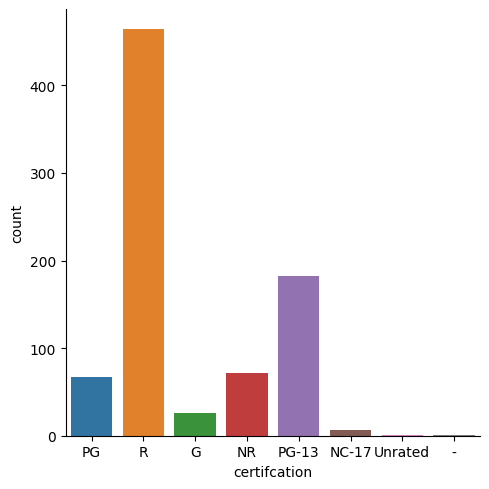

In [48]:
#How many movies are there in each of the certification categories (G/PG/PG-13/R)?
sns.catplot(data = early_2k_movies, x = 'certifcation', kind = 'count');
print(early_2k_movies['certifcation'].value_counts())

In [63]:
#What is the average revenue per certification category?
rev_group = early_2k_movies.groupby(['certifcation'])[['revenue']].mean()
rev_group

,revenue
certifcation,
-,0.000000e+00
G,6.661229e+07
NC-17,1.668286e+03
NR,2.098466e+06
PG,5.868451e+07
PG-13,7.121489e+07
R,1.641628e+07
Unrated,0.000000e+00


In [76]:
# if the above table is hard to read
G = 6.661229e+07
PG = 5.868451e+07
PG13 = 7.121489e+07 
R = 1.641628e+07
NC17 = 1.668286e+03
NR = 2.098466e+06
print('G rated movies had an avg revenue of ${:.0f}'.format(G))
print('PG rated movies had an avg revenue of ${:.0f}'.format(PG))
print('PG13 rated movies had an avg revenue of ${:.0f}'.format(PG13))
print('R rated movies had an avg revenue of ${:.0f}'.format(R))
print('NC17 rated movies had an avg revenue of ${:.3f}'.format(NC17))
print('NR movies had an avg revenue of ${:.0f}'.format(NR))

G rated movies had an avg revenue of $66612290
PG rated movies had an avg revenue of $58684510
PG13 rated movies had an avg revenue of $71214890
R rated movies had an avg revenue of $16416280
NC17 rated movies had an avg revenue of $1668.286
NR movies had an avg revenue of $2098466


<AxesSubplot:xlabel='certifcation', ylabel='revenue'>

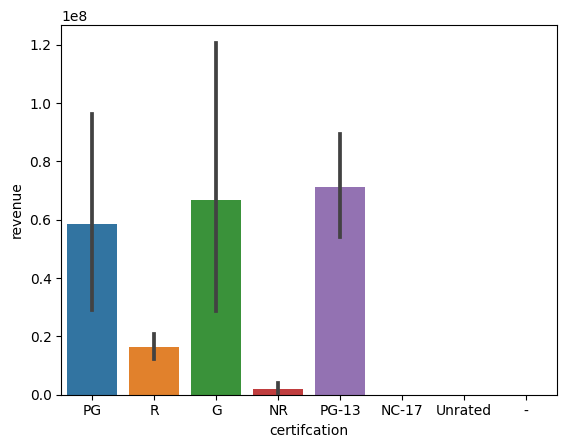

In [93]:
# visualize certification revenue
sns.barplot(data = early_2k_movies, x = 'certifcation', y ='revenue')

In [78]:
# What is the average budget per certification category?
budget_group = early_2k_movies.groupby(['certifcation'])[['budget']].mean()
budget_group

,budget
certifcation,
-,0.000000e+00
G,2.205206e+07
NC-17,0.000000e+00
NR,1.487501e+06
PG,2.349627e+07
PG-13,3.106268e+07
R,9.823285e+06
Unrated,0.000000e+00


In [81]:
# if the above table is hard to read
G = 2.205206e+07
PG = 2.349627e+07
PG13 = 3.106268e+07 
R = 9.823285e+06
NC17 = 	0.000000e+00
NR = 1.487501e+06
print('G rated movies had an avg budget of ${:.0f}'.format(G))
print('PG rated movies had an avg budget of ${:.0f}'.format(PG))
print('PG13 rated movies had an avg budget of ${:.0f}'.format(PG13))
print('R rated movies had an avg budget of ${:.0f}'.format(R))
print('NC17 rated movies had an avg budget of ${:.0f}'.format(NC17))
print('NR movies had an avg budget of ${:.0f}'.format(NR))

G rated movies had an avg budget of $22052060
PG rated movies had an avg budget of $23496270
PG13 rated movies had an avg budget of $31062680
R rated movies had an avg budget of $9823285
NC17 rated movies had an avg budget of $0
NR movies had an avg budget of $1487501


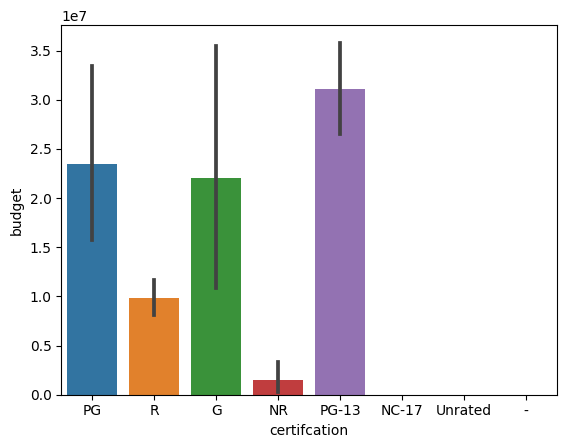

In [100]:
#visualize certification budget
sns.barplot(data = early_2k_movies, x = 'certifcation', y ='budget');